# Example notebook: pipeline walkthrough

This notebook walks through the process of generating a Roman WFI image of a strong lens.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from pyHalo.preset_models import preset_model_from_name

import mejiro
plt.style.use(os.path.join(mejiro.__path__[0], 'mejiro.mplstyle'))
from mejiro.exposure import Exposure
from mejiro.instruments.roman import Roman
from mejiro.galaxy_galaxy import SampleGG
from mejiro.synthetic_image import SyntheticImage
from mejiro.utils import lenstronomy_util
from mejiro.engines.galsim_engine import GalSimEngine
from mejiro.engines.stpsf_engine import STPSFEngine

# Set up a strong lens

In [2]:
strong_lens = SampleGG()

Note that it is parameterized in `lenstronomy` format with `kwargs_model` and `kwargs_params` dictionaries.

In [3]:
pprint(strong_lens.kwargs_model)

{'cosmo': FlatLambdaCDM(name='Planck18',
                        H0=<Quantity 67.66 km / (Mpc s)>,
                        Om0=0.30966,
                        Tcmb0=<Quantity 2.7255 K>,
                        Neff=3.046,
                        m_nu=<Quantity [0.  , 0.  , 0.06] eV>,
                        Ob0=0.04897),
 'lens_light_model_list': ['SERSIC_ELLIPSE'],
 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'],
 'lens_redshift_list': [0.2902115249535011,
                        0.2902115249535011,
                        0.2902115249535011],
 'source_light_model_list': ['SERSIC_ELLIPSE'],
 'source_redshift_list': [0.5876899931818929],
 'z_source': 0.5876899931818929}


In [4]:
pprint(strong_lens.kwargs_params)

{'kwargs_lens': [{'center_x': -0.007876281728887604,
                  'center_y': 0.010633393703246008,
                  'e1': 0.004858808997848661,
                  'e2': 0.0075210751726143355,
                  'theta_E': 1.168082477232392},
                 {'dec_0': 0,
                  'gamma1': -0.03648819840013156,
                  'gamma2': -0.06511863424492038,
                  'ra_0': 0},
                 {'dec_0': 0, 'kappa': 0.06020941823541971, 'ra_0': 0}],
 'kwargs_lens_light': [{'R_sersic': 0.5300707454127908,
                        'center_x': -0.007876281728887604,
                        'center_y': 0.010633393703246008,
                        'e1': 0.023377277902774978,
                        'e2': 0.05349948216860632,
                        'magnitude': None,
                        'n_sersic': 4.0}],
 'kwargs_ps': None,
 'kwargs_source': [{'R_sersic': 0.1651633078964498,
                    'center_x': 0.30298310338567075,
                    'center_y': -

# Add subhalos with `pyhalo`

First, generate a population of CDM subhalos.

Note that `pyhalo` supports a broad range of dark matter models (see its [example notebooks](https://github.com/dangilman/pyHalo/tree/master/example_notebooks)). For instance, once could replace the `CDM` preset model below with the `WDM` preset model to generate a population of warm dark matter subhalos.

In [5]:
z_lens = round(strong_lens.z_lens, 2)
z_source = round(strong_lens.z_source, 2)
log_m_host = np.log10(strong_lens.get_main_halo_mass())
print(
    f'Generating CDM subhalos for lensing galaxy at z={z_lens} and source galaxy at z={z_source} with main halo mass 10^{log_m_host:.2f} solar masses')

CDM = preset_model_from_name('CDM')
realization = CDM(z_lens,
                  z_source,  # pyHalo wants the source redshift to generate line-of-sight halos
                  sigma_sub=0.055,
                  cone_opening_angle_arcsec=3 * strong_lens.get_einstein_radius(),
                  LOS_normalization=0.,  # here's where we exclude line-of-sight halos
                  log_mlow=6.,
                  log_mhigh=10.,
                  log_m_host=log_m_host,
                  r_tidal=0.5)

Generating CDM subhalos for lensing galaxy at z=0.29 and source galaxy at z=0.59 with main halo mass 10^13.40 solar masses


`pyhalo` has nice plotting routines to easily visualize the properties of this unique subhalo population - [from `pyhalo`'s "Basic usage" Jupyter notebook](https://github.com/dangilman/pyHalo/blob/master/example_notebooks/basic_usage.ipynb):

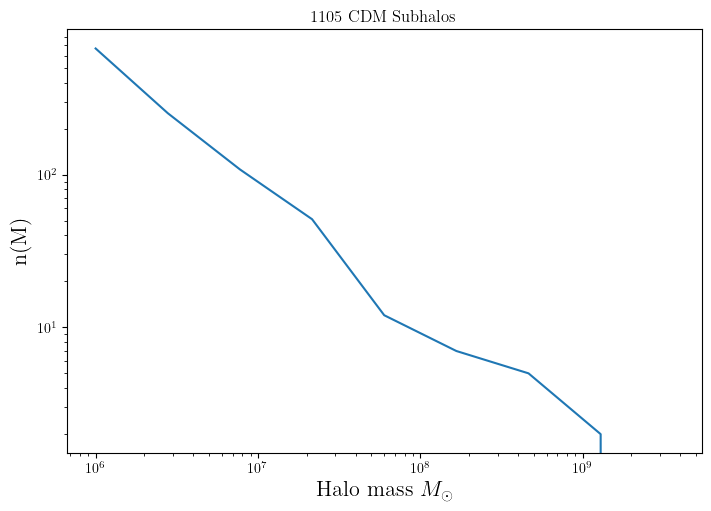

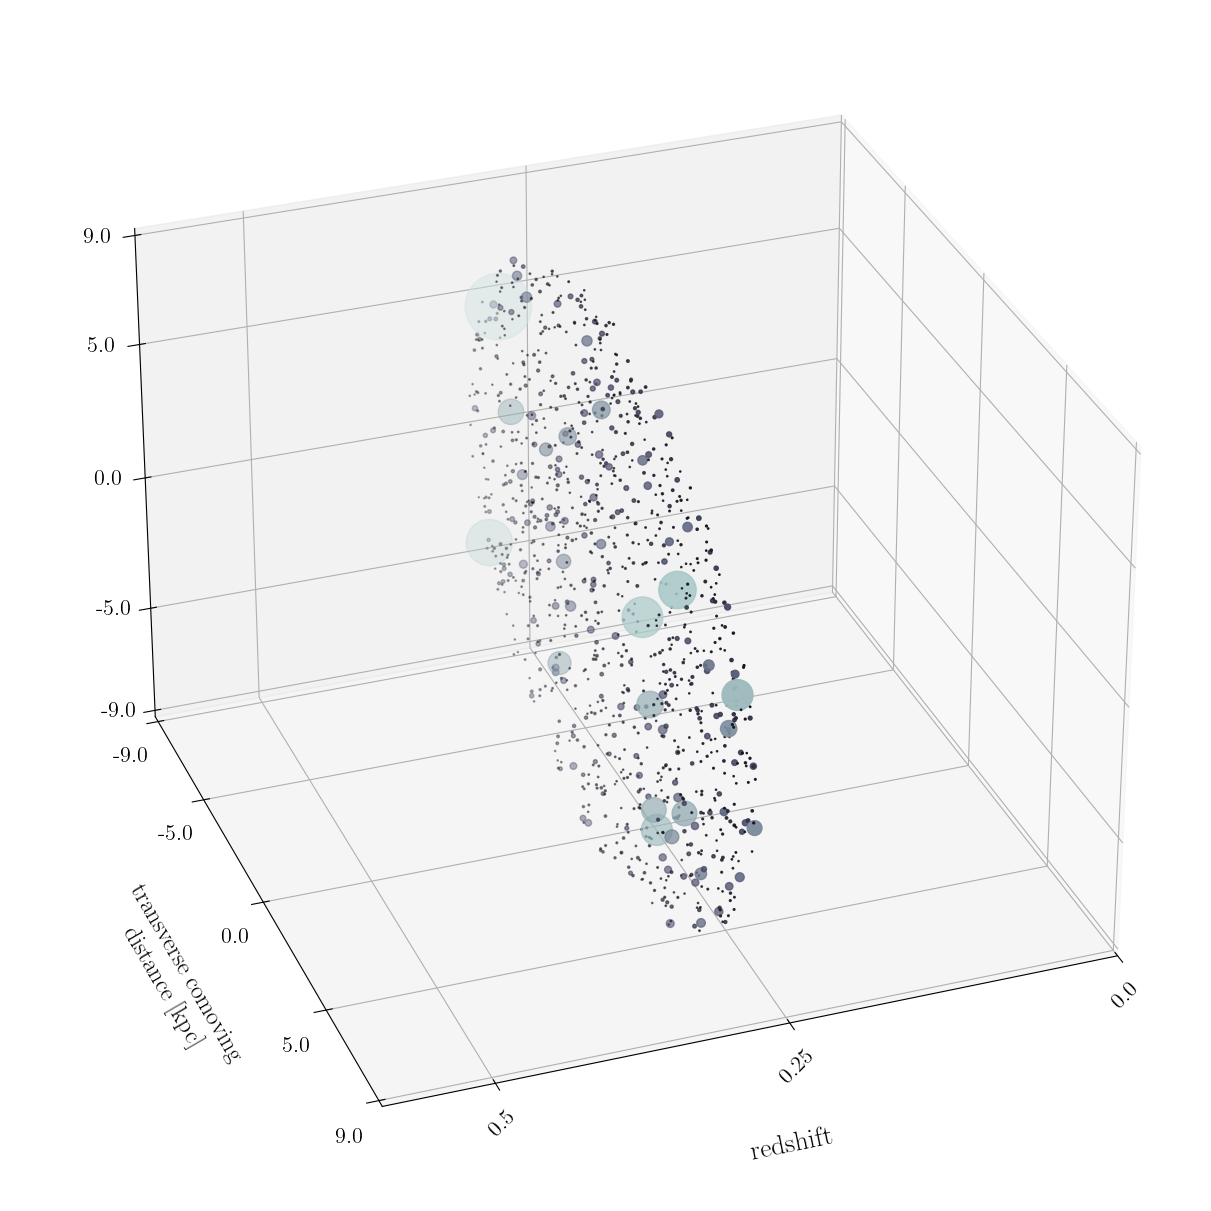

In [6]:
cdm_halo_masses = [halo.mass for halo in realization.halos]
num_subhalos = len(cdm_halo_masses)
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass ' + r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)
ax.set_title(f'{num_subhalos} CDM Subhalos')

fig = plt.figure(figsize=(14, 12))
ax = plt.subplot(111, projection='3d')
realization.plot(ax)

Add this subhalo population to the strong lens model.

In [7]:
strong_lens.add_realization(realization)

# Select an instrument

`mejiro` currently supports image simulation with Roman and the Habitable Worlds Observatory. Here, we select Roman. The `Roman` class carries information about Roman's specifications pulled from [STScI's `roman-technical-information` repository](https://github.com/spacetelescope/roman-technical-information).

In [8]:
roman = Roman()

print(f'roman-technical-information version {roman.versions["roman-technical-information"]} is installed at {roman.roman_technical_information_path}')

roman-technical-information version 1.3.0 is installed at /grad/bwedig/roman-technical-information


# Produce the synthetic image

The "synthetic image" has no noise or detector effects. 

`lenstronomy` is doing the ray-shooting under the hood, so we need to provide `kwargs_numerics` (see `lenstronomy` documentation).

In [9]:
kwargs_numerics = SyntheticImage.DEFAULT_KWARGS_NUMERICS
pprint(kwargs_numerics)

{'compute_indexes': None,
 'compute_mode': 'regular',
 'flux_evaluate_indexes': None,
 'point_source_supersampling_factor': 5,
 'supersampled_indexes': None,
 'supersampling_convolution': True,
 'supersampling_factor': 5,
 'supersampling_kernel_size': None}


For Roman, the synthetic image accounts for SCA-specific zero-point magnitude and the field-dependent PSF, so we must provide it with the `Roman` object and a dictionary of instrument parameters.

In [10]:
instrument_params = roman.default_params()
pprint(instrument_params)

{'detector': 1, 'detector_position': (2048, 2048)}


Finally, we specify the PSF. By default, the `SyntheticImage` class will not convolve the image with any PSF (see `SyntheticImage.DEFAULT_KWARGS_PSF`).

If you don't want to go through the process of setting up STPSF (see installation instructions), grab a copy of `/tests/test_data/F129_1_2048_2048_5_101.npy` and substitute the `STPSFEngine.get_roman_psf()` line in the block below with `kernel = np.load('F129_1_2048_2048_5_101.npy')`.

In [11]:
band = 'F129'

kernel = STPSFEngine.get_roman_psf(band=band,
                                   detector=instrument_params['detector'],
                                   detector_position=instrument_params['detector_position'],
                                   oversample=kwargs_numerics['supersampling_factor'],
                                   num_pix=101,
                                   verbose=True)

kwargs_psf = lenstronomy_util.get_pixel_psf_kwargs(kernel=kernel,
                                                   supersampling_factor=kwargs_numerics['supersampling_factor'])

Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.


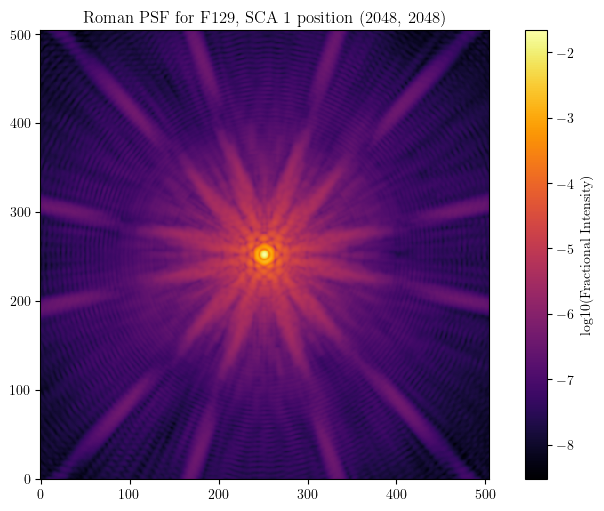

In [12]:
plt.imshow(np.log10(kernel), cmap='inferno')
plt.colorbar(label='log10(Fractional Intensity)')
plt.title(f'{roman.name} PSF for {band}, SCA {instrument_params["detector"]} position {instrument_params["detector_position"]}')
plt.show()

Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix


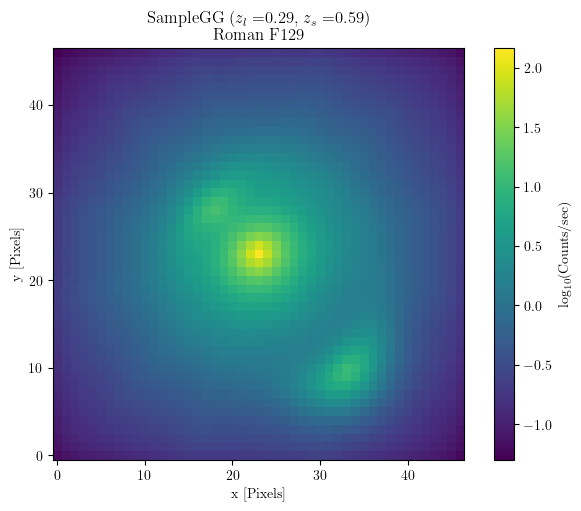

In [13]:
synthetic_image = SyntheticImage(strong_lens,
                                 instrument=roman,
                                 band=band,
                                 fov_arcsec=5,
                                 instrument_params=instrument_params,
                                 kwargs_numerics=kwargs_numerics,
                                 kwargs_psf=kwargs_psf,
                                 pieces=True,
                                 verbose=True)

synthetic_image.plot()

# Apply sky background and detector effects

We do this with the `Exposure` class. Here, we can specify which package we want to use to apply detector effects. Here, we choose `GalSim`.

In [14]:
print(f'Available instruments for {roman.name} are: {roman.engines}')

Available instruments for Roman are: ['galsim', 'romanisim']


In [15]:
engine = 'galsim'
engine_params = GalSimEngine.defaults(roman.name)
pprint(engine_params)

{'dark_noise': True,
 'detector_effects': True,
 'ipc': True,
 'min_zodi_factor': 1.5,
 'nonlinearity': True,
 'poisson_noise': True,
 'read_noise': True,
 'reciprocity_failure': True,
 'rng_seed': 42,
 'sky_background': True}


In [16]:
exposure = Exposure(synthetic_image,
                    exposure_time=107,
                    engine='galsim',
                    engine_params=engine_params,
                    verbose=True)

Exposure calculation time with galsim engine: 0.03 s


Using structure
[[0 1 0]
 [1 1 1]
 [0 1 0]]
Identified 2 region(s)
Region 1: SNR = 150.78003236772165
Region 2: SNR = 1.7884603611540717


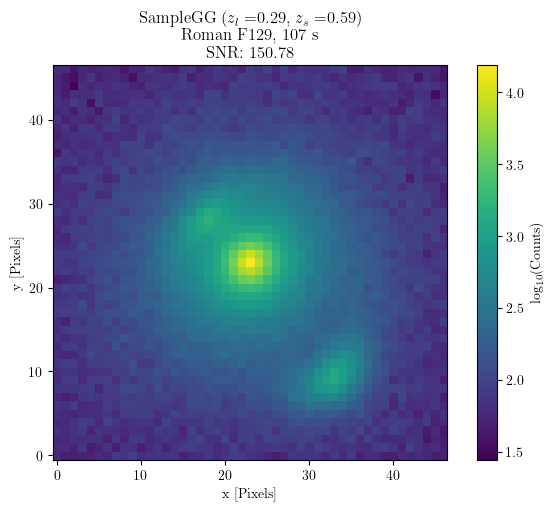

In [17]:
exposure.plot(show_snr=True)